# The Quantum Walk Operator For The Case Of a Line

## The Classical Random Walker

The classical random walke is a concept that describes a path that consists of a succession of random steps in a **space** of one or more dimensions (1D in our case), each step in the serie is taken **randomly** to **any direction** with an associated **probability** for **each** case.

The main purpose of modeling this process is to determine the probability distribution of the walker's position in the the space after $N$ steps.

## One-Dimentional Random walker

Usually this case is considered the simplest, where the walker is considered to be in a one dimentional spcae (a line), we aim to find the probability that the walker will land at position $x = i$ at the end of its $Nth$ step that it takes starting from an inital position (usually $x=0$), each step in the line can be either to the **Right** with probability $Pr$ or to the **Left** with probability $Pl = 1 - Pr$ 

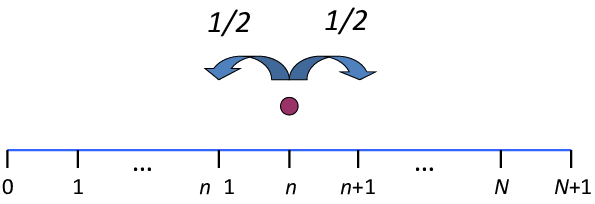

_Fig 1: An illustration of a one-dimensional single random walk._


_Img Credit: Conference paper: On Continuum Limits of Markov Chains and Network Modeling by
Yang Zhang, Edwin K. P. Chong, Jan Hannig, and Donald Estep_

We note that each step at each time is an independent event from any previous step. 

Let $N = 0$ at the start of the walker’s random walk. Each step is initiated by a coin flip. If the coin lands heads the particle moves right, from position $x = i$ to $x = i + 1$ and if the coin lands tails, the walker moves left, from $x = i$ to $x = i - 1$

The walker never stays at the same position during a step, it has to move either right or left.

## The Quantum Walker

The quantum walk is a generalization of the classical random walk using the aspects of quantum mechanics and quantum computing, where in the quantum implemenation the walker explore multiple possible paths which are in a **superposition state** simultaneously

The quantum walk has proven to be a useful tool for quantum 
algorithms, to studl and explain the dynamics in various physical system and solving specefic math problems while providing potential speedups that outperformse its classical counterpart.m walk.



## Difference between the Quantum and the Classical Walker

If we consider that the coin we use to initiate the step in the classical case is fair which means the probabilty of having tail is equal to the probability of having head and it's equal to 0.5 and the initial positionof the walker is $x = 0$ the probability distribution of the final position after the $N$ steps will be a binomial distribution which means that the walker tends to center around it's initial position (0 in this case).

While in the quantum implementation the probability of finding a quantum walker to spread out away from it’s initial position.

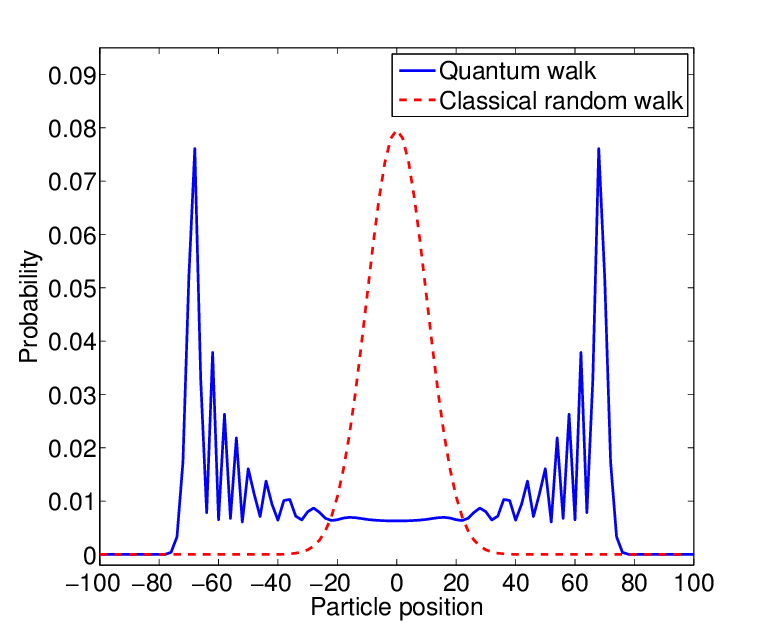

_Fig 1: Probability distribution of classical random walk and its quantum
counterpart, quantum walk. Difference in the variance can been seen in the
distribution. The distribution is after 100 steps of walk._

_Img Credit: Article: Discrete-Time Quantum Walk - Dynamics and Applications by Chandrashekar Madaiah_

## Implementation of the Quantum Walker:

### Objective:
We aim to implement and explain the quantum walker during the following cells

### The Topology of the space:
The $16$ nodes of our space are arranged in a sequential manner where each node is connected only with the its next and previous neighbors, except for the first and the last nodes as shown in the figure:

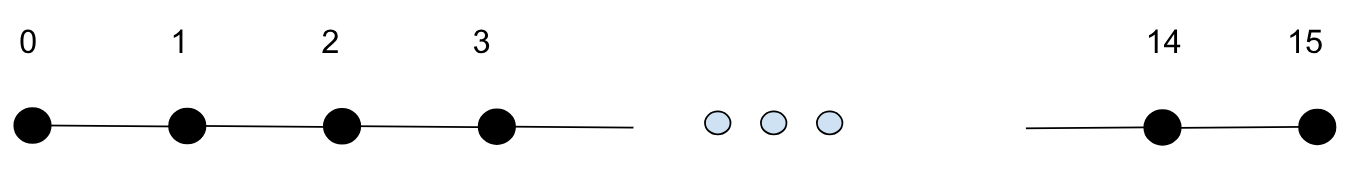

_Fig3: The 16 nodes, 1-D line topology_

_Img Credit: Womanium Classiq Assignment_

The algorithm of the quantum walker operator consists of two main parts as discussed above:

- The Coin Operator (W): which will simulate the assignment of a probabilty for each step
- The Execution Operator (S): which will simulate the shifting of the walker from a place to another during the execution

And here we can find the implementation of each operator:r one by one.r one by one.

In [3]:
from classiq import *
size = 4 #We have 16 nodes so we need 4 qubits to represnt them

## The Coin Operator:

We need to determine the probabilites of the walker, so we need to assign amplitudes for each node to move either left or right, and we will make them even (0.5 for each) except for the first and the last node where the probabilty must be 1 to move forward or backward respectively.

We need a function to prepare the qubits in the  minus state |-> so we can effectively manipulate the probabilties for each node by creating the crucial interference pattern needed

In [4]:
@qfunc
def prepare_minus(x: QBit): 
    X(x) #The X gate
    H(x) #The Hadamard gate

We need to implement the diffuzer oracle  and the zero diffuzer to assign and amplify the amplitudes for each node to make it more likely to observe while measurment (manipulating the probability distribution)

In [5]:
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
    aux^=(x!=0)

@qfunc
def zero_diffuzer(x: QNum):

    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

In [12]:
def Coin_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):

    prob = [0]*16  #Initialize the probability vector for the 16 nodes

    
    if i == 0:
        prob[i + 1] = 1.0  # The first node case => always move forward
    elif i == 15:
        prob[i - 1] = 1.0  # The last node case => always move backward
    else:
        prob[i - 1] = 0.5  # Probability of moving to the left 
        prob[i + 1] = 0.5  # Probability of moving to the right

    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc 
def Coin_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(16):
        Coin_iteration(i,vertices,adjacent_vertices)

## The Shiftting Operator:

After determining the probabilites of each node to be visited, this step execute the walk by swaping the walker between nodes

We need to verify if the two verticies are adjacent

In [7]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices+adjacent_vertices)%2) ==1)


The swap function and the shiftig operator

In [8]:
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i])) 

In [9]:
@qfunc 
def Shift_operator(vertices:QNum, adjacent_vertices: QNum):
    
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

## The main function

As discussed above, the main feature of the quantum walk is its ability to explore all the cases once while they are in a superpositon state, so after allocating the qubites with their right size, we put all the cases in the superposition states using the Hadamard gate and than we can apply our coin operator to assign the amplitudes and the shifting algoriithm to execute the walk.

In [10]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    
    allocate(size, vertices)  # Allocate qubits for the modes
    hadamard_transform(vertices)  # Prepare the superposition using hadamard gate for all the nodes
    allocate(size, adjacent_vertices)  # Allocate qubits for adjacent vertices
    
    Coin_operator(vertices, adjacent_vertices)  # Apply coin operator
    Shift_operator(vertices, adjacent_vertices)  # Apply shift operator

## Creating and synthesizing the circuit

In [13]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/1921133d-481f-4aec-b378-574404cb3643?version=0.43.3


The powerful classiq environment creates the best circuit (ready to be executed on a real quantum machine) with a $Depth = 2470$ and $Width = 25$ as follows:

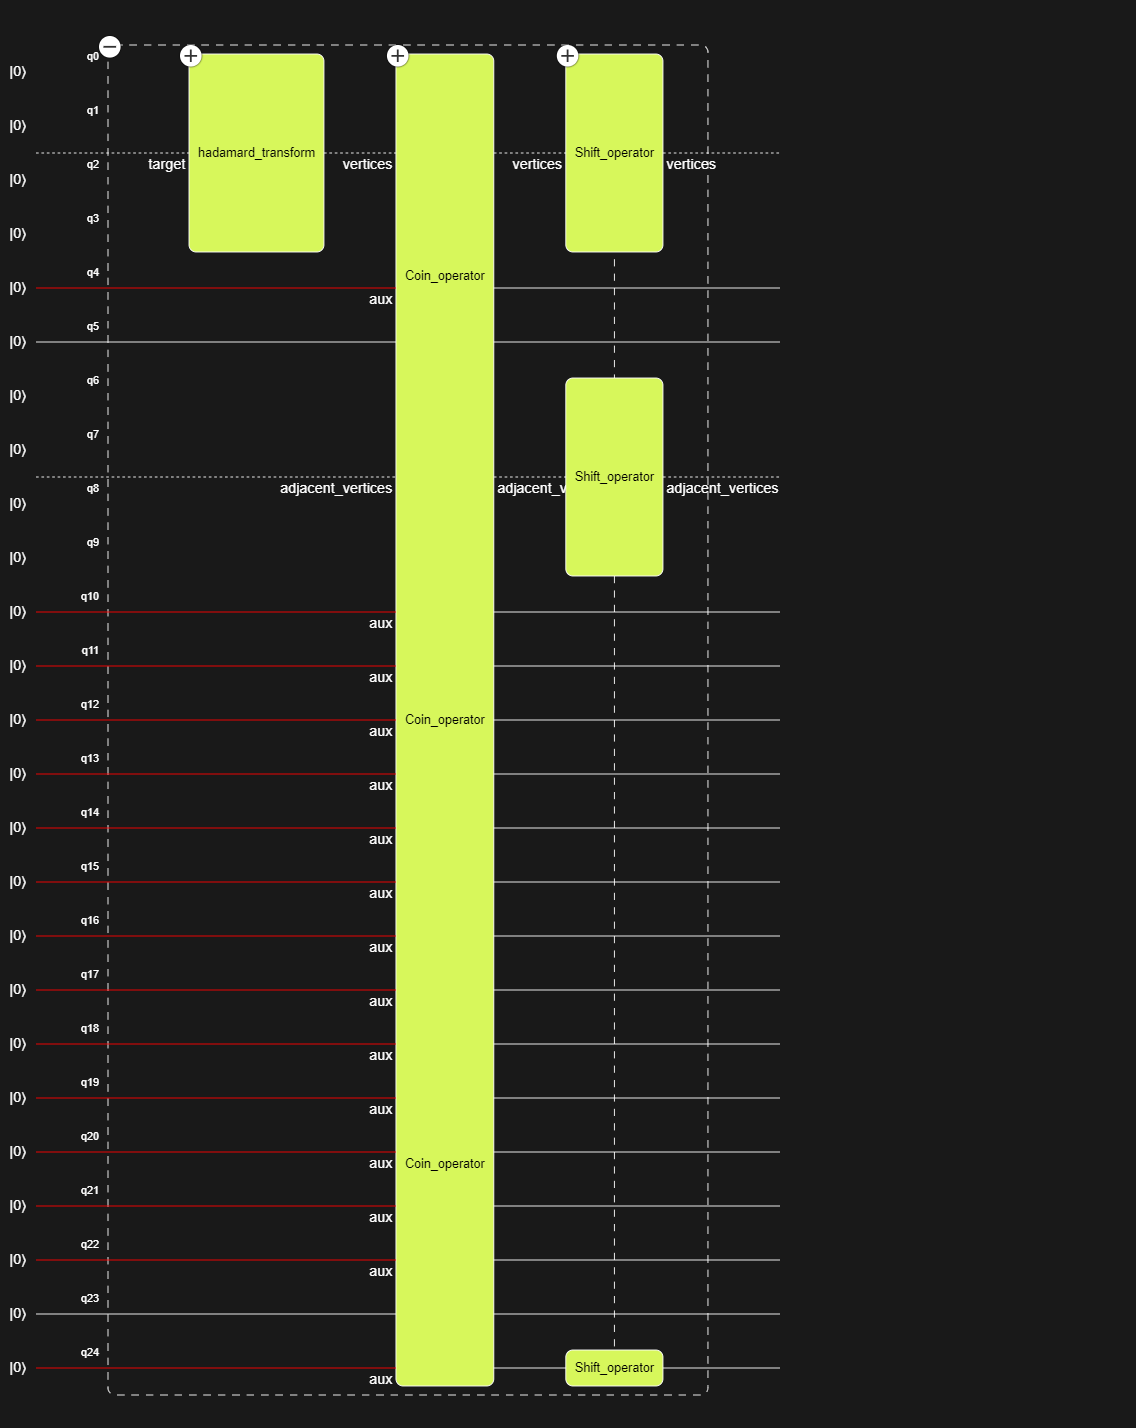

## Conclusion:

The quantum walk algorithm is a great showcase of the potential of the quantum computing, starting from striking the differnces between the classical random walk and the quantum one and based on some physical beahviors we could implement this basic example, and we can assure that the extension of this basic example may be great especially in high dimentional spaces and different topologies.